# XMM-LSS master catalogue

This notebook presents the merge of the various pristine catalogues to produce the HELP master catalogue on XMM-LSS.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]
This notebook was executed on: 
2018-02-20 16:02:41.268950


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
# SXDS now merged in with CANDELS in CFHT merge notebook
#sxds = Table.read("{}/SXDS.fits".format(TMP_DIR)
#                 )["sxds_intid", 
#                   "sxds_ra", 
#                   "sxds_dec",
#                  # 'sxds_flag_merged'
#                  ]                 # 1.11

#WIRCAM:
#cfht_wirds = Table.read("{}/CFHT-WIRDS.fits".format(TMP_DIR)
#                       )["wirds_intid",
#                         "wirds_ra",
#                         "wirds_dec"]     # 1.3

#Megacam:
#candels = Table.read("{}/CANDELS.fits".format(TMP_DIR)
#                    )["candels_id",
#                      "candels_ra",
#                      "candels_dec"]           # 1.1
#cfhtls_wide = Table.read("{}/CFHTLS-WIDE.fits".format(TMP_DIR)
#                        )["cfhtls-wide_id",
#                          "cfhtls-wide_ra",
#                          "cfhtls-wide_dec",
#                          "cfhtls-wide_stellarity"]   # 1.4a
#cfhtls_deep = Table.read("{}/CFHTLS-DEEP.fits".format(TMP_DIR)
#                        )["cfhtls-deep_id",
#                          "cfhtls-deep_ra",
#                          "cfhtls-deep_dec",
#                          "cfhtls-deep_stellarity"]   # 1.4b
#We no longer use CFHTLenS as it is the same raw data set as CFHTLS-WIDE
# cfhtlens = Table.read("{}/CFHTLENS.fits".format(TMP_DIR))         # 1.5
#sparcs = Table.read("{}/SpARCS.fits".format(TMP_DIR)
#                   )['sparcs_intid', 
#                     'sparcs_ra', 
#                     'sparcs_dec', 
#                     'sparcs_stellarity']             # 1.12
#
#vipers = Table.read("{}/VIPERS.fits".format(TMP_DIR)
#                   )["vipers_id",
#                     "vipers_ra",
#                     "vipers_dec"]             # 1.15
cfht = Table.read("{}/cfht_merged_catalogue_xmm-lss.fits".format(TMP_DIR)
                   )['cfht_intid', 
                     "candels_id",
                     "cfhtls-wide_id",
                     "cfhtls-deep_id",
                     'sparcs_intid',
                     'wirds_id',
                     'vipers_id',
                     'sxds_intid',
                     'sxds_b_id',
                     'sxds_v_id',
                     'sxds_r_id',
                     'sxds_i_id',
                     'sxds_z_id',
                     'cfht_ra', 
                     'cfht_dec']             # 1.12



#DECam:
#decals = Table.read("{}/DECaLS.fits".format(TMP_DIR)
#                   )["decals_id",
#                     "decals_ra",
#                     "decals_dec"]             # 1.6
decam = Table.read("{}/decam_merged_catalogue_xmm-lss.fits".format(TMP_DIR)
                   )["decam_intid",
                     "decals_id",
                     "des_id",
                     "decam_ra",
                     "decam_dec"]             # 1.6

#Spitzer IRAC:
#servs = Table.read("{}/SERVS.fits".format(TMP_DIR)
#                  )["servs_intid",
#                    "servs_ra",
#                    "servs_dec"]               # 1.8
#swire = Table.read("{}/SWIRE.fits".format(TMP_DIR)
#                  )["swire_intid",
#                    "swire_ra",
#                    "swire_dec"]               # 1.7
irac = Table.read("{}/irac_merged_catalogue_xmm-lss.fits".format(TMP_DIR)
                  )["irac_intid",
                    "servs_intid",
                    "swire_intid",
                    "irac_ra",
                    "irac_dec"]               # 1.7


#Hyper Suprime Cam:
#hsc_wide = Table.read("{}/HSC-WIDE.fits".format(TMP_DIR)
#                     )["hsc-wide_id",
#                       "hsc-wide_ra",
#                       "hsc-wide_dec", 
#                       "hsc-wide_stellarity"]         # 1.9a
#hsc_deep = Table.read("{}/HSC-DEEP.fits".format(TMP_DIR)
#                     )["hsc-deep_id",
#                       "hsc-deep_ra",
#                       "hsc-deep_dec", 
#                       "hsc-deep_stellarity"]         # 1.9b
#hsc_udeep = Table.read("{}/HSC-UDEEP.fits".format(TMP_DIR)
#                      )["hsc-udeep_id",
#                        "hsc-udeep_ra",
#                        "hsc-udeep_dec", 
#                        "hsc-udeep_stellarity"]       # 1.9c
hsc = Table.read("{}/hsc_merged_catalogue_xmm-lss.fits".format(TMP_DIR)
                      )["hsc_intid",
                        "hsc_ra",
                        "hsc_dec", 
                        "hsc-wide_id",
                        "hsc-deep_id",
                        "hsc-udeep_id"]       # 1.9c


#GPC1:
ps1 = Table.read("{}/PS1.fits".format(TMP_DIR)
                )["ps1_id",
                  "ps1_ra",
                  "ps1_dec"]                   # 1.10

# UKIDSS WFCAM:
#dxs = Table.read("{}/UKIDSS-DXS.fits".format(TMP_DIR)
#                )['dxs_id',
#                  'dxs_ra',
#                  'dxs_dec', 
#                  'dxs_stellarity']            # 1.13
#uds = Table.read("{}/UKIDSS-UDS.fits".format(TMP_DIR)
#                )['uds_id',
#                  'uds_ra',
#                  'uds_dec',
#                  'uds_stellarity']            # 1.14
ukidss = Table.read("{}/ukidss_merged_catalogue_xmm-lss.fits".format(TMP_DIR)
                )['ukidss_intid',
                  'dxs_id',
                  'uds_id',
                  'ukidss_ra',
                  'ukidss_dec',
                 # 'ukidss_stellarity'
                 ]            # 1.14



#VIRCAM:
#vhs = Table.read("{}/VISTA-VHS.fits".format(TMP_DIR)
#                )["vhs_id",
#                  "vhs_ra",
#                  "vhs_dec",
#                  "vhs_stellarity"]             # 1.16
#video = Table.read("{}/VISTA-VIDEO.fits".format(TMP_DIR)
#                  )['video_id',
#                    'video_ra',
#                    'video_dec',
#                    'video_stellarity',
#                    'video_flag_gaia']         # 1.17
#viking = Table.read("{}/VISTA-VIKING.fits".format(TMP_DIR)
#                   )["viking_id",
#                     "viking_ra",
#                     "viking_dec",
#                     "viking_stellarity",
#                     "viking_flag_gaia"]       # 1.18
vircam = Table.read("{}/vista_merged_catalogue_xmm-lss.fits".format(TMP_DIR)
                   )["vircam_intid",
                     "vhs_id",
                     'video_id',
                     "viking_id",
                     "vircam_ra",
                     "vircam_dec",
                     #"vircam_stellarity",
                     #"vircam_flag_gaia"
                    ] 

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones. We start with PanSTARRS because it coevrs the whole field.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### Add PanSTARRS

In [5]:
master_catalogue = ps1
master_catalogue['ps1_ra'].name = 'ra'
master_catalogue['ps1_dec'].name = 'dec'

### CANDELS

We now use CANDELS-UDS which must be individually merged with the merged catalogues since it has measurements from different instruments

In [6]:
#nb_merge_dist_plot(
#    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
#    SkyCoord(candels['candels_ra'], candels['candels_dec'])
#)

In [7]:
# Given the graph above, we use 0.8 arc-second radius
#master_catalogue = merge_catalogues(master_catalogue, candels, "candels_ra", "candels_dec", radius=0.8*u.arcsec)

### Add CFHT

We independently merge all the CFHT Megacam and WIRCAM and some CANDELS in CFHT_Merge notebook 

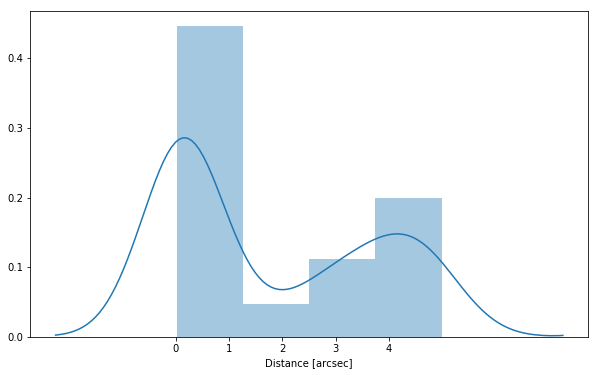

In [8]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(cfht['cfht_ra'], cfht['cfht_dec'])
)

In [9]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, 
                                    cfht, 
                                    "cfht_ra", 
                                    "cfht_dec", 
                                    radius=0.8*u.arcsec)


### Add HSC-PSS

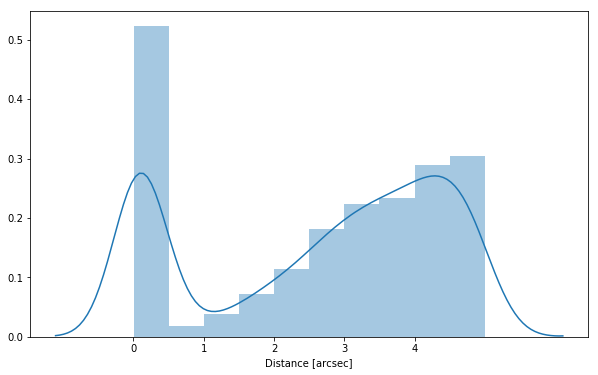

In [10]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(hsc['hsc_ra'], hsc['hsc_dec'])
)

In [11]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, hsc, "hsc_ra", "hsc_dec", radius=0.8*u.arcsec)


### Add DECam (DES and DECaLS)

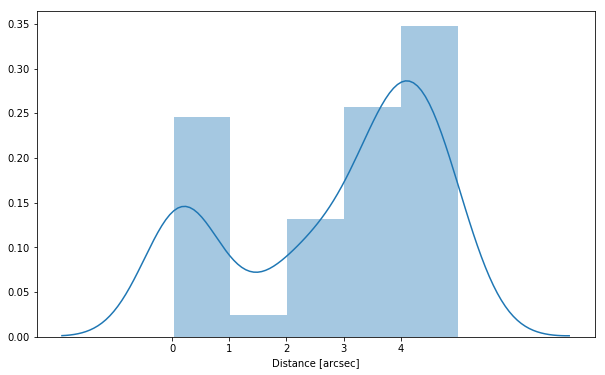

In [12]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(decam['decam_ra'], decam['decam_dec'])
)

In [13]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, decam, "decam_ra", "decam_dec", radius=0.8*u.arcsec)

### Add SXDS

This now happens in CFHT merging notebook because CANDELS contains Suprime fluxes which need merging

In [14]:
# nb_merge_dist_plot(
#     SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
#     SkyCoord(sxds['sxds_ra'], sxds['sxds_dec'])
# )

It is strange that this does not peak at zero. This is bservable in the original band cross match. It implies there is a persistent offset. Perhaps each band should be astrometrically corrected before the original merge.

In [15]:
#sxds['flag_merged'].name = 'flag_merged_sxds'

In [16]:
# # Given the graph above, we use 0.8 arc-second radius
# master_catalogue = merge_catalogues(master_catalogue, sxds, "sxds_ra", "sxds_dec", radius=1.0*u.arcsec)

### Add UKIDSS

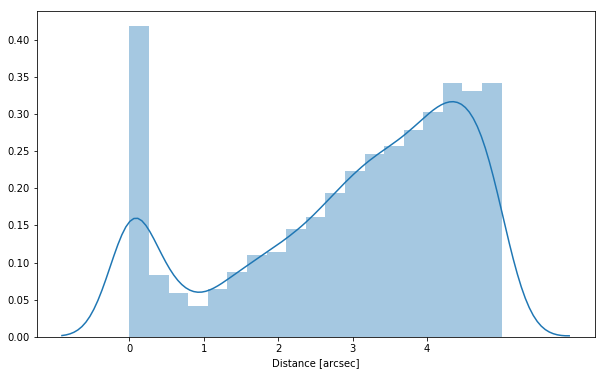

In [17]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(ukidss['ukidss_ra'], ukidss['ukidss_dec'])
)

In [18]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, ukidss, "ukidss_ra", "ukidss_dec", radius=0.8*u.arcsec)

### Add VIRCAM

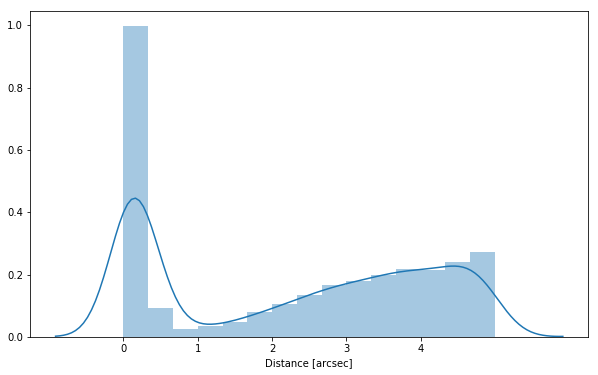

In [19]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(vircam['vircam_ra'], vircam['vircam_dec'])
)

In [20]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, vircam, "vircam_ra", "vircam_dec", radius=0.8*u.arcsec)

### Add IRAC

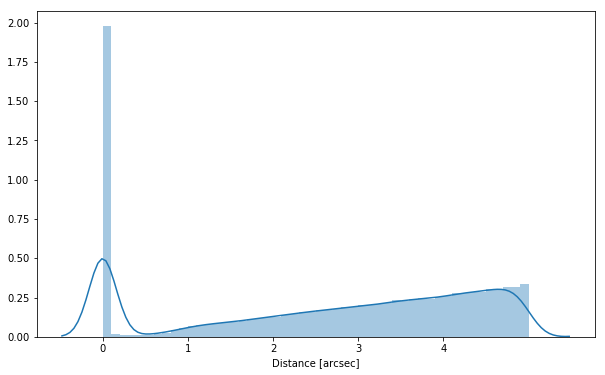

In [21]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(irac['irac_ra'], irac['irac_dec'])
)

In [22]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, irac, "irac_ra", "irac_dec", radius=1.*u.arcsec)

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [23]:
for col in master_catalogue.colnames:
    #print(col)
    if (col.startswith("m_") or col.startswith("merr_") or col.startswith("f_") or col.startswith("ferr_")):
        master_catalogue[col] = master_catalogue[col].astype(float)
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [24]:
master_catalogue[:10].show_in_notebook()

idx,ps1_id,ra,dec,flag_merged,cfht_intid,candels_id,cfhtls-wide_id,cfhtls-deep_id,sparcs_intid,wirds_id,vipers_id,sxds_intid,sxds_b_id,sxds_v_id,sxds_r_id,sxds_i_id,sxds_z_id,hsc_intid,hsc-wide_id,hsc-deep_id,hsc-udeep_id,decam_intid,decals_id,des_id,ukidss_intid,dxs_id,uds_id,vircam_intid,vhs_id,video_id,viking_id,irac_intid,servs_intid,swire_intid
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,103040354349392544,35.4349721923,-4.13153415525,False,-1,-1,,,-1,-1,-1,-1,,,,,,,-1,-1,-1,,-1,-1,,-1,-1,,-1,-1,-1,-1,-1,-1
1,102780349050858385,34.9051226823,-4.34320021525,False,-1,-1,,,-1,-1,-1,-1,,,,,,,-1,-1,-1,,-1,-1,,-1,-1,,-1,-1,-1,-1,-1,-1
2,103140350761899669,35.0762068823,-4.04235938525,False,-1,-1,,,-1,-1,-1,-1,,,,,,,-1,-1,-1,,-1,-1,,-1,-1,,-1,-1,-1,-1,-1,-1
3,102900349018459901,34.9018332223,-4.24209351525,False,-1,-1,,,-1,-1,-1,-1,,,,,,,-1,-1,-1,,-1,-1,,-1,-1,,-1,-1,-1,-1,-1,-1
4,103160348848772693,34.8848419323,-4.03145872525,False,-1,-1,,,-1,-1,-1,-1,,,,,,,-1,-1,-1,,-1,-1,,-1,-1,,-1,-1,-1,-1,-1,-1
5,103140350759269559,35.0759661923,-4.04239428525,False,-1,-1,,,-1,-1,-1,-1,,,,,,,-1,-1,-1,,-1,-1,,-1,-1,,-1,-1,-1,-1,-1,-1
6,103090355560196593,35.5558866523,-4.08643243525,False,-1,-1,,,-1,-1,-1,-1,,,,,,,-1,-1,-1,,-1,-1,,-1,-1,,-1,-1,-1,-1,-1,-1
7,103210354713793274,35.4714062823,-3.98929835525,False,-1,-1,,,-1,-1,-1,-1,,,,,,,-1,-1,-1,,-1,-1,,-1,-1,,-1,-1,-1,-1,-1,-1
8,102540353459707198,35.3460365923,-4.54431680525,False,-1,-1,,,-1,-1,-1,-1,,,,,,,-1,-1,-1,,-1,-1,,-1,-1,,-1,-1,-1,-1,-1,-1


## III - Merging flags and stellarity

This all happens at the end now after the catalogue has been cut into strips.

## IV - Adding E(B-V) column

In [25]:
master_catalogue.add_column(
    ebv(master_catalogue['ra'], master_catalogue['dec'])
)

## V - Adding HELP unique identifiers and field columns

In [26]:
master_catalogue.add_column(Column(gen_help_id(master_catalogue['ra'], master_catalogue['dec']),
                                   name="help_id"))
master_catalogue.add_column(Column(np.full(len(master_catalogue), "XMM-LSS", dtype='<U18'),
                                   name="field"))

In [27]:
# Check that the HELP Ids are unique
if len(master_catalogue) != len(np.unique(master_catalogue['help_id'])):
    print("The HELP IDs are not unique!!!")
else:
    print("OK!")

OK!


## VI - Cross-matching with spec-z catalogue

In [28]:
specz =  Table.read("../../dmu23/dmu23_XMM-LSS/data/XMM-LSS-specz-v2.8.fits")

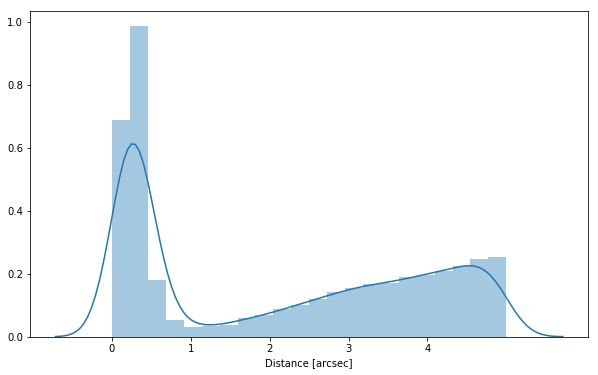

In [29]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(specz['ra'] * u.deg, specz['dec'] * u.deg)
)

In [30]:
master_catalogue = specz_merge(master_catalogue, specz, radius=1. * u.arcsec)

## VIII.a Wavelength domain coverage

We add a binary `flag_optnir_obs` indicating that a source was observed in a given wavelength domain:

- 1 for observation in optical;
- 2 for observation in near-infrared;
- 4 for observation in mid-infrared (IRAC).

It's an integer binary flag, so a source observed both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: The observation flag is based on the creation of multi-order coverage maps from the catalogues, this may not be accurate, especially on the edges of the coverage.*

*Note 2: Being on the observation coverage does not mean having fluxes in that wavelength domain. For sources observed in one domain but having no flux in it, one must take into consideration the different depths in the catalogue we are using.*

In [31]:
#candels_moc =   MOC(filename="../../dmu0/dmu0_CANDELS-3D-HST/data/CANDELS-3D-HST_XMM-LSS_MOC.fits") # 1.1
candels_moc = MOC(filename="../../dmu0/dmu0_CANDELS-UDS/data/hlsp_candels_hst_wfc3_uds-tot-multiband_f160w_v1_MOC.fits") # 1.2
cfht_wirds_moc =  MOC(filename="../../dmu0/dmu0_CFHT-WIRDS/data/XMM-LSS_Ks-priors_MOC.fits")        # 1.3
cfhtls_wide_moc = MOC(filename="../../dmu0/dmu0_CFHTLS/data/CFHTLS-WIDE_XMM-LSS_MOC.fits")          # 1.4a
cfhtls_deep_moc = MOC(filename="../../dmu0/dmu0_CFHTLS/data/CFHTLS-DEEP_XMM-LSS_MOC.fits")          # 1.4b
cfhtls_moc = cfhtls_wide_moc + cfhtls_deep_moc
#cfhtlens_moc = MOC(filename="../../dmu0/dmu0_CFHTLenS/data/CFHTLenS_XMM-LSS_MOC.fits")              # 1.5
decals_moc =  MOC(filename="../../dmu0/dmu0_DECaLS/data/DECaLS_XMM-LSS_MOC.fits")                   # 1.6
des_moc =  MOC(filename="../../dmu0/dmu0_DES/data/DES-DR1_XMM-LSS_MOC.fits")                   # 1.6
decam_moc = decals_moc + des_moc
servs_moc = MOC(filename="../../dmu0/dmu0_DataFusion-Spitzer/data/DF-SERVS_XMM-LSS_MOC.fits")       # 1.8
swire_moc = MOC(filename="../../dmu0/dmu0_DataFusion-Spitzer/data/DF-SWIRE_XMM-LSS_MOC.fits")       # 1.7
hsc_wide_moc = MOC(filename="../../dmu0/dmu0_HSC/data/HSC-PDR1_wide_XMM-LSS_MOC.fits")              # 1.9a
hsc_deep_moc = MOC(filename="../../dmu0/dmu0_HSC/data/HSC-PDR1_deep_XMM-LSS_MOC.fits")              # 1.9b
hsc_udeep_moc = MOC(filename="../../dmu0/dmu0_HSC/data/HSC-PDR1_uDeep_XMM-LSS_MOC.fits")            # 1.9c
hsc_moc = hsc_wide_moc + hsc_deep_moc + hsc_udeep_moc
ps1_moc = MOC(filename="../../dmu0/dmu0_PanSTARRS1-3SS/data/PanSTARRS1-3SS_XMM-LSS_MOC.fits")       # 1.10
sxds_moc = MOC(filename="../../dmu0/dmu0_SXDS/data/dmu0_SXDS_MOC.fits")                             # 1.11
sparcs_moc = MOC(filename="../../dmu0/dmu0_SpARCS/data/SpARCS_HELP_XMM-LSS_MOC.fits")               # 1.12
dxs_moc = MOC(filename="../../dmu0/dmu0_UKIDSS-DXS_DR10plus/data/UKIDSS-DR10plus_XMM-LSS_MOC.fits") # 1.13
uds_moc =  MOC(filename="../../dmu0/dmu0_UKIDSS-UDS/data/UKIDSS-UDS_XMM-LSS_MOC.fits")              # 1.14
vipers_moc =  MOC(filename="../../dmu0/dmu0_VIPERS-MLS/data/VIPERS-MLS_20160502_MOC.fits")          # 1.15
vhs_moc =   MOC(filename="../../dmu0/dmu0_VISTA-VHS/data/VHS_XMM-LSS_MOC.fits")                     # 1.16
video_moc =  MOC(filename="../../dmu0/dmu0_VISTA-VIDEO-private/data/VIDEO-all_2016-04-14_fullcat_errfix_XMM-LSS_MOC.fits")         # 1.17
viking_moc = MOC(filename="../../dmu0/dmu0_VISTA-VIKING/data/VIKING_XMM-LSS_MOC.fits")              # 1.18

In [32]:
was_observed_optical = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    (candels_moc + 
     cfht_wirds_moc + 
     cfhtls_moc + 
     #cfhtlens_moc + 
     sparcs_moc + 
     decam_moc + 
     hsc_moc + 
     ps1_moc) )

was_observed_nir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    dxs_moc + uds_moc + vhs_moc + video_moc + viking_moc
)

was_observed_mir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    servs_moc + swire_moc
)

In [33]:
master_catalogue.add_column(
    Column(
        1 * was_observed_optical + 2 * was_observed_nir + 4 * was_observed_mir,
        name="flag_optnir_obs")
)

## VIII.b Wavelength domain detection

We add a binary `flag_optnir_det` indicating that a source was detected in a given wavelength domain:

- 1 for detection in optical;
- 2 for detection in near-infrared;
- 4 for detection in mid-infrared (IRAC).

It's an integer binary flag, so a source detected both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: We use the total flux columns to know if the source has flux, in some catalogues, we may have aperture flux and no total flux.*

To get rid of artefacts (chip edges, star flares, etc.) we consider that a source is detected in one wavelength domain when it has a flux value in **at least two bands**. That means that good sources will be excluded from this flag when they are on the coverage of only one band.

In [34]:
# SpARCS is a catalogue of sources detected in r (with fluxes measured at 
# this prior position in the other bands).  Thus, we are only using the r
# CFHT band.
# Check to use catalogue flags from HSC and PanSTARRS.
#nb_optical_flux = np.zeros(len(master_catalogue), dtype=float)

#nb_nir_flux = np.zeros(len(master_catalogue), dtype=float)

#nb_mir_flux = np.zeros(len(master_catalogue), dtype=float)

In [35]:
#has_optical_flux = nb_optical_flux >= 2
#has_nir_flux = nb_nir_flux >= 2
#has_mir_flux = nb_mir_flux >= 2

#master_catalogue.add_column(
#    Column(
#        1 * has_optical_flux + 2 * has_nir_flux + 4 * has_mir_flux,
#        name="flag_optnir_det")
#)

## IX - Cross-identification table

We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogues. This can be used to easily get additional information from them.

For convenience, we also cross-match the master list with the SDSS catalogue and add the objID associated with each source, if any. **TODO: should we correct the astrometry with respect to Gaia positions?**

In [36]:
#
# Addind SDSS ids
#
sdss = Table.read("../../dmu0/dmu0_SDSS-DR13/data/SDSS-DR13_XMM-LSS.fits")['objID', 'ra', 'dec']
sdss_coords = SkyCoord(sdss['ra'] * u.deg, sdss['dec'] * u.deg)
idx_ml, d2d, _ = sdss_coords.match_to_catalog_sky(SkyCoord(master_catalogue['ra'], master_catalogue['dec']))
idx_sdss = np.arange(len(sdss))

# Limit the cross-match to 1 arcsec
mask = d2d <= 1. * u.arcsec
idx_ml = idx_ml[mask]
idx_sdss = idx_sdss[mask]
d2d = d2d[mask]
nb_orig_matches = len(idx_ml)

# In case of multiple associations of one master list object to an SDSS object, we keep only the
# association to the nearest one.
sort_idx = np.argsort(d2d)
idx_ml = idx_ml[sort_idx]
idx_sdss = idx_sdss[sort_idx]
_, unique_idx = np.unique(idx_ml, return_index=True)
idx_ml = idx_ml[unique_idx]
idx_sdss = idx_sdss[unique_idx]
print("{} master list rows had multiple associations.".format(nb_orig_matches - len(idx_ml)))

# Adding the ObjID to the master list
master_catalogue.add_column(Column(data=np.full(len(master_catalogue), -1, dtype='>i8'), name="sdss_id"))
master_catalogue['sdss_id'][idx_ml] = sdss['objID'][idx_sdss]

11 master list rows had multiple associations.


In [37]:
id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)


['ps1_id', 'cfht_intid', 'candels_id', 'cfhtls-wide_id', 'cfhtls-deep_id', 'sparcs_intid', 'wirds_id', 'vipers_id', 'sxds_intid', 'sxds_b_id', 'sxds_v_id', 'sxds_r_id', 'sxds_i_id', 'sxds_z_id', 'hsc_intid', 'hsc-wide_id', 'hsc-deep_id', 'hsc-udeep_id', 'decam_intid', 'decals_id', 'des_id', 'ukidss_intid', 'dxs_id', 'uds_id', 'vircam_intid', 'vhs_id', 'video_id', 'viking_id', 'irac_intid', 'servs_intid', 'swire_intid', 'help_id', 'specz_id', 'sdss_id']


In [38]:
master_catalogue[id_names].write(
    "{}/master_list_cross_ident_xmm-lss{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)
id_names.remove('help_id')
#master_catalogue.remove_columns(id_names)

## X - Adding HEALPix index

We are adding a column with a HEALPix index at order 13 associated with each source.

In [39]:
master_catalogue.add_column(Column(
    data=coords_to_hpidx(master_catalogue['ra'], master_catalogue['dec'], order=13),
    name="hp_idx"
))

## XI - Saving the catalogue

In [40]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    
    
columns += ["stellarity", "stellarity_origin", "flag_cleaned", "flag_merged", "flag_gaia", "flag_optnir_obs", "flag_optnir_det", 
            "zspec", "zspec_qual", "zspec_association_flag", "ebv"]

In [41]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

Missing columns: {'vipers_id', 'vircam_intid', 'viking_id', 'hsc_intid', 'hsc-deep_id', 'hsc-wide_id', 'des_id', 'sxds_i_id', 'swire_intid', 'sxds_z_id', 'candels_id', 'cfht_intid', 'sxds_r_id', 'irac_intid', 'ps1_id', 'specz_id', 'servs_intid', 'wirds_id', 'decam_intid', 'dxs_id', 'cfhtls-wide_id', 'video_id', 'cfhtls-deep_id', 'sparcs_intid', 'decals_id', 'sxds_v_id', 'sxds_intid', 'sdss_id', 'hsc-udeep_id', 'sxds_b_id', 'ukidss_intid', 'vhs_id', 'uds_id'}


In [42]:
#master_catalogue[columns].write("{}/master_catalogue_xmm-lss_low-memory{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

## XII - folding in the photometry
On XMM-LSS there is too much data to load all in to memory at once so we perform the cross matching without photometry columns. Only now do we fold in the photometry data by first cutting the catalogue up in to manageable sizes.

In [43]:
split_length = 100000 #number of sources to include in every sub catalogue
num_files = int(np.ceil(len(master_catalogue)/split_length))
print(num_files)


20


In [44]:
#Sort catalogue by HELP id so that it is split up in RA strips
master_catalogue.sort('help_id')
#Remove all the old ids as they interfere with join
old_id_names = [
 'candels_id',
 'cfhtls-wide_id',
 'cfhtls-deep_id',
 'sparcs_intid',
 'wirds_id',
 'vipers_id',
 'sxds_intid',
 'sxds_b_id',
 'sxds_v_id',
 'sxds_r_id',
 'sxds_i_id',
 'sxds_z_id',
    
 'hsc-wide_id',
 'hsc-deep_id',
 'hsc-udeep_id',
    
 'des_id',
 'decals_id',

 'dxs_id',
 'uds_id',
 
 'vhs_id',
 'video_id',
 'viking_id',

 'servs_intid',
 'swire_intid']
master_catalogue.remove_columns(old_id_names)
# The old id names will be added back in by 
# the join so I leave them in the list here to be 
# removed before the save of the sub catalogue
# id_names.remove(old_id_names)

In [45]:
#There is candels data on three seperate merged catalogues so duplicates must be removed from two
irac_merged = Table.read("{}/irac_merged_catalogue_xmm-lss.fits".format(TMP_DIR))
irac_merged.remove_columns(['candels_id',
                            'candels_stellarity',
                            'candels_flag_cleaned',
                            'candels_flag_gaia'])

ukidss_merged = Table.read("{}/ukidss_merged_catalogue_xmm-lss.fits".format(TMP_DIR))
ukidss_merged.remove_columns(['candels_id',
                              'candels_stellarity',
                              'candels_flag_cleaned',
                              'candels_flag_gaia'])

In [46]:
surveys = [
    

    #['sxds',         "SXDS.fits",           Table.read("{}/SXDS.fits".format(TMP_DIR)),          'sxds_intid'], 
    #['candels',      "CANDELS.fits",        Table.read("{}/CANDELS.fits".format(TMP_DIR)),       'candels_id'],
    #['cfhtls_wide',  "CFHTLS-WIDE.fits",    Table.read("{}/CFHTLS-WIDE.fits".format(TMP_DIR)),   'cfhtls-wide_id'],
    #['cfhtls_deep',  "CFHTLS-DEEP.fits",    Table.read("{}/CFHTLS-DEEP.fits".format(TMP_DIR)),   'cfhtls-deep_id'],
    #['sparcs',       "SpARCS.fits",         Table.read("{}/SpARCS.fits".format(TMP_DIR)),        'sparcs_intid'], 
    #['cfht_wirds',   "CFHT-WIRDS.fits",     Table.read("{}/CFHT-WIRDS.fits".format(TMP_DIR)),    'wirds_intid' ],
    #['vipers',       "VIPERS.fits",         Table.read("{}/VIPERS.fits".format(TMP_DIR)),        'vipers_id'],
    ['cfht',       
     "cfht_merged_catalogue_xmm-lss.fits",        
     Table.read("{}/cfht_merged_catalogue_xmm-lss.fits".format(TMP_DIR)),        
     'cfht_intid'], 
    
    #['decals',       "DECaLS.fits",         Table.read("{}/DECaLS.fits".format(TMP_DIR)),        'decals_id'],
    ['decam',       
     "decam_merged_catalogue_xmm-lss.fits",         
     Table.read("{}/decam_merged_catalogue_xmm-lss.fits".format(TMP_DIR)),        
     'decam_intid'],
    
    #['servs',        "SERVS.fits",          Table.read("{}/SERVS.fits".format(TMP_DIR)),         'servs_intid'],
    #['swire',        "SWIRE.fits",          Table.read("{}/SWIRE.fits".format(TMP_DIR)),         'swire_intid'],  
    ['irac',       
     "irac_merged_catalogue_xmm-lss.fits",
     irac_merged,        
     'irac_intid'], 
    
    #['hsc_wide ',    "HSC-WIDE.fits",       Table.read("{}/HSC-WIDE.fits".format(TMP_DIR)),      'hsc-wide_id' ],
    #['hsc_deep',     "HSC-DEEP.fits",       Table.read("{}/HSC-DEEP.fits".format(TMP_DIR)),      'hsc-deep_id'],
    #['hsc_udeep',    "HSC-UDEEP.fits",      Table.read("{}/HSC-UDEEP.fits".format(TMP_DIR)),     'hsc-udeep_id'],  
    ['hsc',       
     "hsc_merged_catalogue_xmm-lss.fits",        
     Table.read("{}/hsc_merged_catalogue_xmm-lss.fits".format(TMP_DIR)),        
     'hsc_intid'], 
    
    ['ps1',          "PS1.fits",            Table.read("{}/PS1.fits".format(TMP_DIR)),           'ps1_id'],    
    
                  
    
    #['dxs',          "UKIDSS-DXS.fits",     Table.read("{}/UKIDSS-DXS.fits".format(TMP_DIR)),    'dxs_id'],          
    #['uds',          "UKIDSS-UDS.fits",     Table.read("{}/UKIDSS-UDS.fits".format(TMP_DIR)),    'uds_id'],    
    ['ukidss',       
     "ukidss_merged_catalogue_xmm-lss.fits",        
     ukidss_merged,         
     'ukidss_intid'], 
    
   
    
    #['vhs',          "VISTA-VHS.fits",      Table.read("{}/VISTA-VHS.fits".format(TMP_DIR)),     'vhs_id'],           
    #['video',        "VISTA-VIDEO.fits",    Table.read("{}/VISTA-VIDEO.fits".format(TMP_DIR)),   'video_id'],       
    #['viking',       "VISTA-VIKING.fits",   Table.read("{}/VISTA-VIKING.fits".format(TMP_DIR)), 'viking_id']  
    ['vircam',       
     "vista_merged_catalogue_xmm-lss.fits",        
     Table.read("{}/vista_merged_catalogue_xmm-lss.fits".format(TMP_DIR)),        
     'vircam_intid']
]

In [47]:
n=0
for sub_file in range(num_files):
    
    sub_catalogue = master_catalogue[n*split_length:(n+1)*split_length]
    #print(n)
    for survey in surveys:
        #print(survey[0])
        sub_catalogue = join(sub_catalogue, 
                               survey[2], #Table.read("{}/{}".format(TMP_DIR, survey[1])),
                               join_type='left',
                               metadata_conflicts='silent',
                               keys=survey[3]
                            )
        
        
        
    #Each pristine catalogue contains a flag indicating if the source was associated to a another nearby source that was removed during the cleaning process. We merge these flags in a single one.


    flag_cleaned_columns = [column for column in sub_catalogue.colnames
                            if 'flag_cleaned' in column]

    flag_column = np.zeros(len(sub_catalogue), dtype=bool)
    for column in flag_cleaned_columns:
        flag_column |= sub_catalogue[column]
    
    sub_catalogue.add_column(Column(data=flag_column, name="flag_cleaned"))
    sub_catalogue.remove_columns(flag_cleaned_columns)
    #combining the flag_merged column which contains information regarding multiple associations
    
    
    sub_catalogue['flag_merged'].name = 'flag_merged_tmp'
    flag_merged_columns = [column for column in sub_catalogue.colnames
                            if 'flag_merged' in column]
    
    flag_merged_column = np.zeros(len(sub_catalogue), dtype=bool)
    for column in flag_merged_columns:
        flag_merged_column |= sub_catalogue[column]
    
    sub_catalogue.add_column(Column(data=flag_merged_column, name="flag_merged"))
    sub_catalogue.remove_columns(flag_merged_columns)

    #Each pristine catalogue contains a flag indicating the probability of a source being a Gaia object (0: not a Gaia object, 1: possibly, 2: probably, 3: definitely). We merge these flags taking the highest value.


    flag_gaia_columns = [column for column in sub_catalogue.colnames
                         if 'flag_gaia' in column]

    sub_catalogue.add_column(Column(
        data=np.max([sub_catalogue[column] for column in flag_gaia_columns], axis=0),
        name="flag_gaia"
    ))
    sub_catalogue.remove_columns(flag_gaia_columns)
    #Each prisitine catalogue may contain one or several stellarity columns indicating the #probability (0 to 1) of each source being a star. We merge these columns taking the highest value. We keep trace of the origin of the stellarity.



    stellarity_columns = [column for column in sub_catalogue.colnames
                          if 'stellarity' in column]

    #print(", ".join(stellarity_columns))



    # We create an masked array with all the stellarities and get the maximum value, as well as its
    # origin.  Some sources may not have an associated stellarity.
    stellarity_array = np.array([sub_catalogue[column] for column in stellarity_columns])
    stellarity_array = np.ma.masked_array(stellarity_array, np.isnan(stellarity_array))

    max_stellarity = np.max(stellarity_array, axis=0)
    max_stellarity.fill_value = np.nan

    no_stellarity_mask = max_stellarity.mask

    sub_catalogue.add_column(Column(data=max_stellarity.filled(), name="stellarity"))

    stellarity_origin = np.full(len(sub_catalogue), "NO_INFORMATION", dtype="S20")
    stellarity_origin[~no_stellarity_mask] = np.array(stellarity_columns)[np.argmax(stellarity_array, axis=0)[~no_stellarity_mask]]

    sub_catalogue.add_column(Column(data=stellarity_origin, name="stellarity_origin"))

    sub_catalogue.remove_columns(stellarity_columns)

    for col in sub_catalogue.colnames:
        #print(col)
        if (col.startswith("m_") or col.startswith("merr_") or col.startswith("f_") or col.startswith("ferr_")):
            sub_catalogue[col] = sub_catalogue[col].astype(float)
            sub_catalogue[col].fill_value = np.nan
        elif "flag" in col:
            sub_catalogue[col].fill_value = 0
        elif "id" in col:
            sub_catalogue[col].fill_value = -1
        
    sub_catalogue = sub_catalogue.filled()
        
        
    nb_optical_flux = (
        # CANDELS
        1 * ~np.isnan(sub_catalogue['f_acs_f606w']) + 
        1 * ~np.isnan(sub_catalogue['f_acs_f814w']) +
        1 * ~np.isnan(sub_catalogue['f_wfc3_f125w']) +
        1 * ~np.isnan(sub_catalogue['f_wfc3_f160w']) +

        # DES and DECaLS
        1 * ~np.isnan(sub_catalogue['f_decam_g']) + 
        1 * ~np.isnan(sub_catalogue['f_decam_r']) +
        1 * ~np.isnan(sub_catalogue['f_decam_i']) +
        1 * ~np.isnan(sub_catalogue['f_decam_z']) +
        1 * ~np.isnan(sub_catalogue['f_decam_y']) +
        # HSC
        1 * ~np.isnan(sub_catalogue['f_suprime_g']) + 
        1 * ~np.isnan(sub_catalogue['f_suprime_r']) +
        1 * ~np.isnan(sub_catalogue['f_suprime_i']) +
        1 * ~np.isnan(sub_catalogue['f_suprime_z']) +
        1 * ~np.isnan(sub_catalogue['f_suprime_y']) +
        1 * ~np.isnan(sub_catalogue['f_suprime_n921']) +
        1 * ~np.isnan(sub_catalogue['f_suprime_n816']) +
        # PanSTARRS
        1 * ~np.isnan(sub_catalogue['f_gpc1_g']) +
        1 * ~np.isnan(sub_catalogue['f_gpc1_r']) +
        1 * ~np.isnan(sub_catalogue['f_gpc1_i']) +
        1 * ~np.isnan(sub_catalogue['f_gpc1_z']) +
        1 * ~np.isnan(sub_catalogue['f_gpc1_y']) +
        # CFHT
        1 * ~np.isnan(sub_catalogue['f_megacam_u']) +
        1 * ~np.isnan(sub_catalogue['f_megacam_g']) +
        1 * ~np.isnan(sub_catalogue['f_megacam_r']) +
        1 * ~np.isnan(sub_catalogue['f_megacam_z']) +
        1 * ~np.isnan(sub_catalogue['f_megacam_y']) 
    )

    nb_nir_flux = (
        # CFHT-WIRCAM
        1 * ~np.isnan(sub_catalogue['f_wircam_j']) +
        1 * ~np.isnan(sub_catalogue['f_wircam_h']) +
        1 * ~np.isnan(sub_catalogue['f_wircam_ks']) +
        # UKIDSS
        1 * ~np.isnan(sub_catalogue['f_ukidss_j']) +
        1 * ~np.isnan(sub_catalogue['f_ukidss_h']) +
        1 * ~np.isnan(sub_catalogue['f_ukidss_k']) +
        # VISTA
        1 * ~np.isnan(sub_catalogue['f_vista_z']) +
        1 * ~np.isnan(sub_catalogue['f_vista_y']) +
        1 * ~np.isnan(sub_catalogue['f_vista_j']) +
        1 * ~np.isnan(sub_catalogue['f_vista_h']) +
        1 * ~np.isnan(sub_catalogue['f_vista_ks'])
    )

    nb_mir_flux = (
        1 * ~np.isnan(sub_catalogue['f_irac_i1']) +
        1 * ~np.isnan(sub_catalogue['f_irac_i2']) +
        1 * ~np.isnan(sub_catalogue['f_irac_i3']) +
        1 * ~np.isnan(sub_catalogue['f_irac_i4']) 
    )
        
    has_optical_flux = nb_optical_flux >= 2
    has_nir_flux = nb_nir_flux >= 2
    has_mir_flux = nb_mir_flux >= 2

    sub_catalogue.add_column(
        Column(
            1 * has_optical_flux + 2 * has_nir_flux + 4 * has_mir_flux,
            name="flag_optnir_det")
    )
        
    #print('Finished join')
    sub_catalogue.remove_columns(id_names)
    #sub_catalogue.remove_columns(['sxds_b_id', 'sxds_v_id', 'sxds_r_id', 'sxds_i_id', 'sxds_z_id'])
    
    for col in sub_catalogue.colnames:
        if col.endswith('_ra'):
            sub_catalogue.remove_column(col)
        if col.endswith('_dec'):
            sub_catalogue.remove_column(col)
        if '_vircam_' in col:
            sub_catalogue.rename_column(col, col.replace('_vircam_', '_vista_'))
            

    
    
    
    sub_catalogue.write("{}/tiles/sub_catalogue_xmm-lss{}_{}.fits".format(OUT_DIR, SUFFIX, n), overwrite=True)
    n += 1

## How to generate final catalogue
After this notebook has been run there will be a set of sub catalogues in data/tiles/

These need to be stacked using stilts:

<pre>
suffix=20180111

ls ./data/tiles/sub_catalogue_xmm-lss_$suffix_*.fits > ./data/tiles/fits_list_$suffix.lis

stilts tcat in=@./data/tiles/fits_list_$suffix.lis out=./data/master_catalogue_xmm-lss_$suffix.fits
</pre>

For many purposes this file may be too large. In order to run checks and diagnostics we typically take a subset using something like:

<pre>
stilts tpipe cmd='every 10' ./data/master_catalogue_xmm-lss_$suffix.fits omode=out out=./data/master_catalogue_xmm-lss_RANDOM10PCSAMPLE_$suffix.fits
</pre>